In [1]:
!git clone https://github.com/salesforce/PCL.git
%cd PCL



Cloning into 'PCL'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 160 (delta 18), reused 12 (delta 12), pack-reused 134 (from 2)
Receiving objects: 100% (160/160), 196.36 KiB | 922.00 KiB/s, done.
Resolving deltas: 100% (55/55), done.
/content/PCL


In [2]:
!pip install torch torchvision
!pip install numpy tqdm pyyaml

In [3]:
import torch
print(torch.cuda.is_available())  # True
print(torch.cuda.get_device_name(0))  #GPU name

True
Tesla T4


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
DATASET_PATH = "/content/drive/My Drive/dataset"

In [6]:
%cd /content/PCL


/content/PCL


In [7]:
!pip install faiss-cpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 68.4 MB/s eta 0:00:00


In [8]:
import torch
import torch.nn as nn

In [18]:
import importlib
import sys
import pcl.builder as builder

# Print where the module is loaded from
print("Reloaded from:", builder.__file__)

# Force reload and confirm
builder = importlib.reload(builder)
print("After reload:", builder.__file__)

# Check if MoCo exists
print("MoCo available?", hasattr(builder, "MoCo"))

# Print id to confirm new module object
print("Module id:", id(builder))


Reloaded from: /content/PCL/pcl/builder.py
After reload: /content/PCL/pcl/builder.py
MoCo available? True
Module id: 140098461302304


In [19]:
import sys
sys.path.insert(0, "/content/PCL")  # force project path

from pcl import builder
print("Builder path:", builder.__file__)
print("Has MoCo:", hasattr(builder, "MoCo"))


Builder path: /content/PCL/pcl/builder.py
Has MoCo: True


In [12]:
import os, sys
sys.path.append('/content/PCL')

from pcl import builder
print("✅ Import worked!")

import sys
sys.path.insert(0, "/content/PCL")


✅ Import worked!


In [ ]:
%reset -f

In [16]:
builder_path = "/content/PCL/pcl/builder.py"

# Read the existing builder.py
with open(builder_path, "r") as f:
    original_code = f.read()

# Only add MoCo if it's not already defined
if "class MoCo" not in original_code:
    moco_code = """
class MoCo(nn.Module):
    \"\"\"Build a MoCo model with: a query encoder, a key encoder, and a queue.\"\"\"
    def __init__(self, base_encoder, dim=128, r=16384, m=0.999, T=0.1, mlp=False):
        super(MoCo, self).__init__()
        self.r = r
        self.m = m
        self.T = T
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.encoder_q = base_encoder(num_classes=dim).to(self.device)
        self.encoder_k = base_encoder(num_classes=dim).to(self.device)

        if mlp:
            dim_mlp = self.encoder_q.fc.weight.shape[1]
            self.encoder_q.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.encoder_q.fc)
            self.encoder_k.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.encoder_k.fc)

        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)
            param_k.requires_grad = False

        self.register_buffer("queue", torch.randn(dim, r))
        self.queue = nn.functional.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        keys = concat_all_gather(keys)
        batch_size = keys.shape[0]
        ptr = int(self.queue_ptr)
        assert self.r % batch_size == 0
        self.queue[:, ptr:ptr + batch_size] = keys.T
        ptr = (ptr + batch_size) % self.r
        self.queue_ptr[0] = ptr

    @torch.no_grad()
    def _batch_shuffle_ddp(self, x):
        idx_unshuffle = None
        return x, idx_unshuffle

    @torch.no_grad()
    def _batch_unshuffle_ddp(self, x, idx_unshuffle):
        return x

    def forward(self, im_q, im_k=None, is_eval=False, cluster_result=None, index=None):
        im_q = im_q.to(self.device)
        if im_k is not None:
            im_k = im_k.to(self.device)
        if index is not None:
            index = index.to(self.device)

        if is_eval:
            self.encoder_k.eval()
            k = self.encoder_k(im_q)
            k = nn.functional.normalize(k, dim=1)
            return k

        with torch.no_grad():
            self._momentum_update_key_encoder()
            im_k, idx_unshuffle = self._batch_shuffle_ddp(im_k)
            k = self.encoder_k(im_k)
            k = nn.functional.normalize(k, dim=1)
            k = self._batch_unshuffle_ddp(k, idx_unshuffle)

        q = self.encoder_q(im_q)
        q = nn.functional.normalize(q, dim=1)

        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach().to(self.device)])
        logits = torch.cat([l_pos, l_neg], dim=1)
        logits /= self.T
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(self.device)
        self._dequeue_and_enqueue(k)
        return logits, labels, None, None

@torch.no_grad()
def concat_all_gather(tensor):
    return tensor
"""
    # Append the MoCo definition
    with open(builder_path, "a") as f:
        f.write("\n" + moco_code)

print("MoCo class appended to builder.py")


MoCo class appended to builder.py


In [17]:
import sys
sys.path.insert(0, "/content/PCL")

from pcl import builder
print("MoCo available?", hasattr(builder, "MoCo"))


MoCo available? True


In [21]:
!python3 /content/PCL/main_pcl.py \
  "/content/drive/My Drive/dataset_cropped" \
  --arch resnet34 \
  --epochs 300 \
  --batch-size 32 \
  --lr 0.0005 \
  --temperature 0.1 \
  --num-cluster 3

Streaming output truncated to the last 5000 lines.
  Preprocessing in 0.00 s
Outer iteration 0 / 5
  Iteration 19 (0.00 s, search 0.00 s): objective=4.80123 imbalance=1.070 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 19 (0.00 s, search 0.00 s): objective=5.02102 imbalance=1.102 nsplit=0       
Outer iteration 2 / 5
  Iteration 19 (0.00 s, search 0.00 s): objective=4.80444 imbalance=1.070 nsplit=0       
Outer iteration 3 / 5
  Iteration 19 (0.01 s, search 0.00 s): objective=5.04723 imbalance=1.050 nsplit=0       
Outer iteration 4 / 5
  Iteration 19 (0.01 s, search 0.00 s): objective=4.82419 imbalance=1.026 nsplit=0       
Epoch: [36][0/8]	Time  4.405 ( 4.405)	Data  4.091 ( 4.091)	Loss 8.4231e+00 (8.4231e+00)	Acc@Inst   0.00 (  0.00)	Acc@Proto   0.00 (  0.00)
[DEBUG] Epoch 37 | warmup_epoch = 0 | Clustering will run: True
Computing features...
100% 2/2 [00:03<00:00,  1.63s/it]
performing kmeans clustering
Clustering 279 points in 128D to 3 cl

Using checkpoint: /content/PCL/experiment_pcl/checkpoint_0299.pth.tar


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


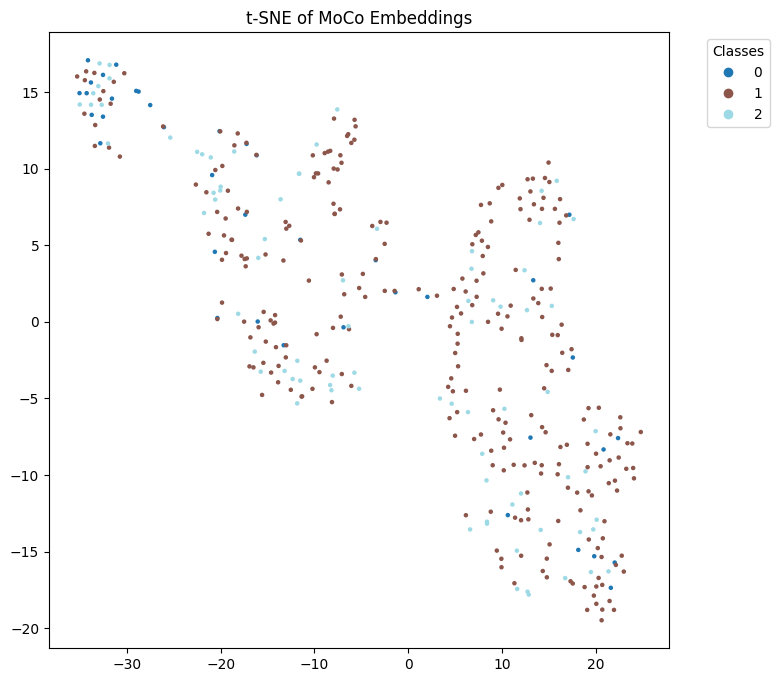

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


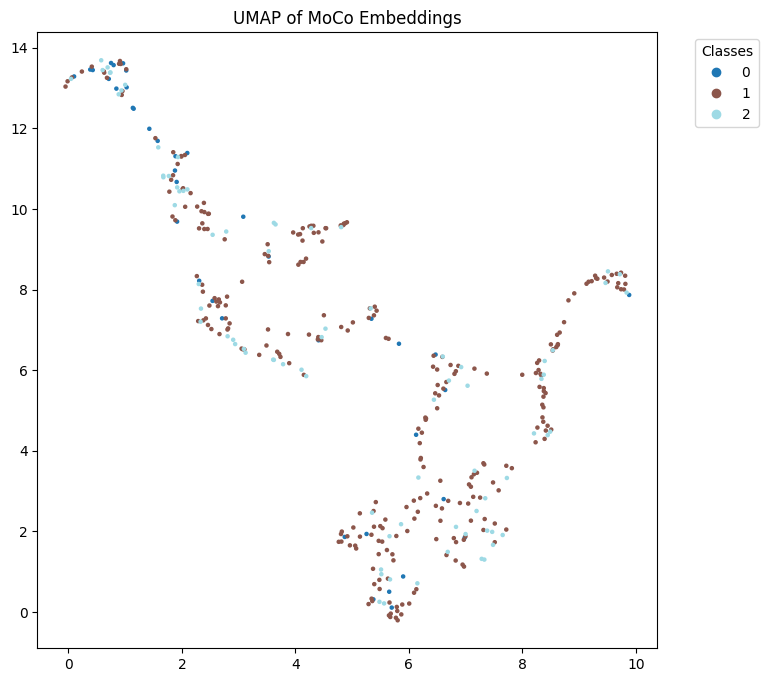

NMI: 0.2360
ARI: 0.0000
Silhouette Score: -0.0030


In [22]:
# --- Install dependencies ---
!pip install faiss-cpu umap-learn scikit-learn matplotlib

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, silhouette_score
import numpy as np
import umap
import glob
from pcl import builder
import torchvision.models as models

# --- Find latest checkpoint ---
checkpoints = sorted(glob.glob("/content/PCL/experiment_pcl/checkpoint_*.pth.tar"))
checkpoint_path = checkpoints[-1]  # latest checkpoint
print("Using checkpoint:", checkpoint_path)

# --- Manually set args used in training ---
arch = "resnet34"
low_dim = 128
pcl_r = 4
moco_m = 0.999
temperature = 0.1
mlp = True

# --- Build MoCo model ---
model = builder.MoCo(
    models.__dict__[arch],
    low_dim,
    pcl_r,
    moco_m,
    temperature,
    mlp
)

# --- Load checkpoint but remove queue ---
ckpt = torch.load(checkpoint_path, map_location="cpu")
state_dict = ckpt['state_dict']
state_dict = {k: v for k, v in state_dict.items() if not k.startswith('queue')}
model.load_state_dict(state_dict, strict=False)
model.eval().cuda()

# --- Dataset & DataLoader ---
data_path = "/content/drive/MyDrive/dataset_cropped"
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(data_path, transform)
loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

# --- Feature extraction ---
all_features = []
all_labels = []

with torch.no_grad():
    for imgs, labels in loader:
        imgs = imgs.cuda(non_blocking=True)
        feats = model.encoder_q(imgs)  # MoCo encoder
        feats = torch.nn.functional.normalize(feats, dim=1)
        all_features.append(feats.cpu())
        all_labels.append(labels)

all_features = torch.cat(all_features, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

# --- t-SNE Visualization ---
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_embeds = tsne.fit_transform(all_features)

plt.figure(figsize=(8, 8))
scatter = plt.scatter(tsne_embeds[:, 0], tsne_embeds[:, 1], c=all_labels, cmap="tab20", s=5)
plt.legend(*scatter.legend_elements(), title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE of MoCo Embeddings")
plt.show()

# --- UMAP Visualization ---
umap_embeds = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(all_features)
plt.figure(figsize=(8, 8))
scatter = plt.scatter(umap_embeds[:, 0], umap_embeds[:, 1], c=all_labels, cmap="tab20", s=5)
plt.legend(*scatter.legend_elements(), title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("UMAP of MoCo Embeddings")
plt.show()

# --- Clustering Metrics ---
nmi = normalized_mutual_info_score(all_labels, np.argmax(all_features @ all_features.T, axis=1))
ari = adjusted_rand_score(all_labels, np.argmax(all_features @ all_features.T, axis=1))
sil = silhouette_score(all_features, all_labels)

print(f"NMI: {nmi:.4f}")
print(f"ARI: {ari:.4f}")
print(f"Silhouette Score: {sil:.4f}")


In [23]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import glob
from pcl import builder
import torchvision.models as models

# -------------------------------
# Load latest checkpoint
# -------------------------------
checkpoints = sorted(glob.glob("/content/PCL/experiment_pcl/checkpoint_*.pth.tar"))
checkpoint_path = checkpoints[-1]
print("Using checkpoint:", checkpoint_path)

# --- MoCo args (ResNet-34 backbone) ---
arch = "resnet34"
low_dim = 128
pcl_r = 4
moco_m = 0.999
temperature = 0.1
mlp = True

# --- Build MoCo model ---
model = builder.MoCo(
    models.__dict__[arch],
    low_dim,
    pcl_r,
    moco_m,
    temperature,
    mlp
)

# --- Load checkpoint but remove queue ---
ckpt = torch.load(checkpoint_path, map_location="cpu")
state_dict = ckpt['state_dict']
state_dict = {k: v for k, v in state_dict.items() if not k.startswith('queue')}
model.load_state_dict(state_dict, strict=False)
model.eval().cuda()

# -------------------------------
# Dataset & DataLoader
# -------------------------------
train_dir = "/content/drive/My Drive/dataset_cropped/train"
test_dir  = "/content/drive/My Drive/dataset_cropped/test"

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset  = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))

# -------------------------------
# Feature Extraction
# -------------------------------
def extract_features(dataloader):
    features, labels = [], []
    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.cuda(non_blocking=True)
            feats = model.encoder_q(imgs)  # use MoCo encoder_q
            feats = F.normalize(feats, dim=1)  # normalize embeddings
            features.append(feats.cpu())
            labels.append(lbls)
    return torch.cat(features), torch.cat(labels)

train_features, train_labels = extract_features(train_loader)
test_features, test_labels   = extract_features(test_loader)

# -------------------------------
# Centroid-based Classification
# -------------------------------
def compute_centroids(features, labels, num_classes):
    centroids = []
    for c in range(num_classes):
        mask = labels == c
        class_feats = features[mask]
        centroid = class_feats.mean(dim=0)
        centroids.append(centroid)
    return torch.stack(centroids)

num_classes = len(train_dataset.classes)
centroids = compute_centroids(train_features, train_labels, num_classes)
centroids = F.normalize(centroids, dim=1)

def predict_with_centroids(test_feats, centroids):
    sims = test_feats @ centroids.T  # cosine similarity
    preds = torch.argmax(sims, dim=1)
    return preds

pred_labels = predict_with_centroids(test_features, centroids)

# -------------------------------
# Evaluation Metrics
# -------------------------------
y_true = test_labels.numpy()
y_pred = pred_labels.numpy()

acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")  # Sensitivity
f1 = f1_score(y_true, y_pred, average="macro")

# Specificity per class
cm = confusion_matrix(y_true, y_pred)
specificity = []
for i in range(num_classes):
    tn = cm.sum() - (cm[i,:].sum() + cm[:,i].sum() - cm[i,i])
    fp = cm[:,i].sum() - cm[i,i]
    specificity.append(tn / (tn + fp))
specificity = np.mean(specificity)

# -------------------------------
# Print Results
# -------------------------------
print("Confusion Matrix:\n", cm)
print(f"Accuracy:     {acc:.16f}")
print(f"Precision:    {precision:.16f}")
print(f"Sensitivity:  {recall:.16f}")
print(f"F1 Score:     {f1:.16f}")
print(f"Specificity:  {specificity:.16f}")


Using checkpoint: /content/PCL/experiment_pcl/checkpoint_0299.pth.tar
Train size: 279
Test size: 39


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Confusion Matrix:
 [[ 9  2  2]
 [ 0  2 11]
 [ 0  1 12]]
Accuracy:     0.5897435897435898
Precision:    0.6266666666666666
Sensitivity:  0.5897435897435898
F1 Score:     0.5573276625908204
Specificity:  0.7948717948717948
